# Import the packages and libraries

In [1]:
import pandas as pd
pd.options.display.max_columns=60

import numpy as np
import sys

from matplotlib import style
style.use('ggplot')

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.tsa.arima_process as sta
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.statespace as sts

import warnings
warnings.filterwarnings(action='once')
from util_formula import *


/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/home/zhou/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/zhou/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/zhou/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# 0- reading data and summary statistics

In [2]:
train = pd.read_csv('data/P2train.csv', parse_dates=['Time'],index_col='Time',header=0)
test = pd.read_csv('data/P2test.csv', parse_dates=['Time'],index_col='Time',header=0)
test_index = pd.read_csv('data/P2test_index.csv', header=0)

In [3]:
#Outliers spotten. Potential solution : interpolation
train[train.Temp<200]
# T<200 Kelvin <=> T <-75 °C
train[train.Rain1h>2000]

,IsHoliday,Temp,Rain1h,Snow1h,CloudsAll,WeatherMain,WeatherDescription,TrafficVolume
Time,,,,,,,,
2016-07-11 17:00:00,None,302.11,9831.3,0.0,75,Rain,very heavy rain,5535


## Data Exploration

/home/zhou/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


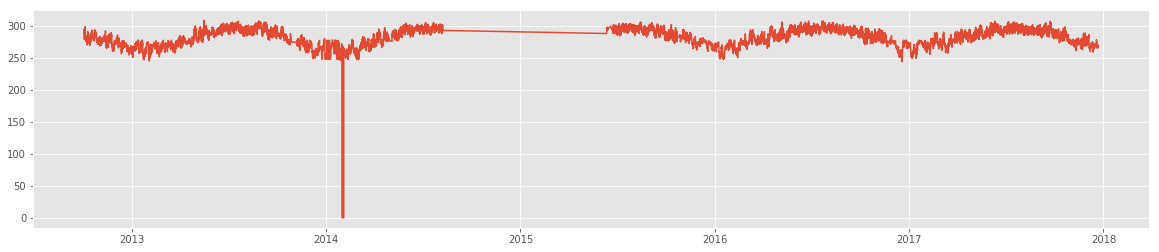

In [4]:
# plot the time series data
fig = plt.figure(figsize=(20,4))
plt.plot(train.Temp)

Text(0.5, 1.0, 'TrafficVolume by time for 1 week')

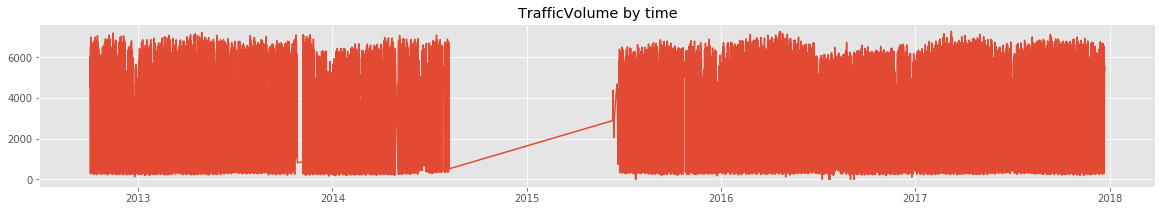

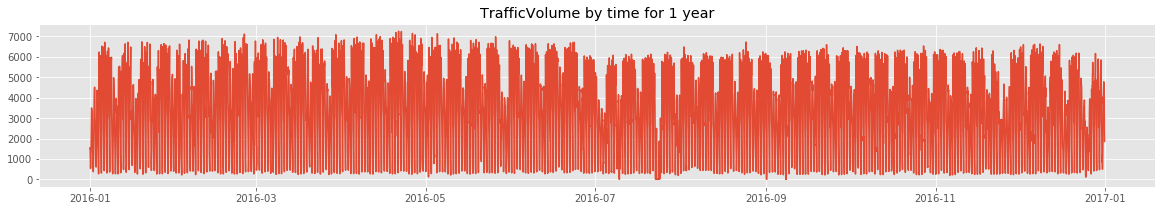

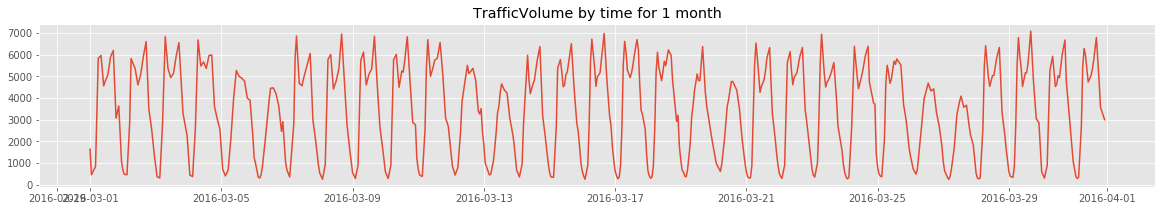

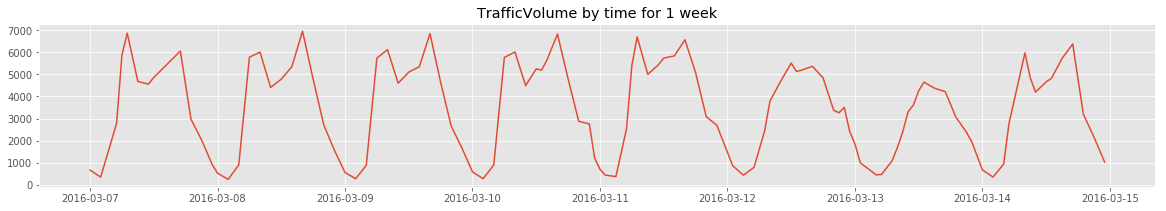

In [5]:
fig = plt.figure(figsize=(20,3))
plt.plot(train.TrafficVolume)
plt.title('TrafficVolume by time')

fig = plt.figure(figsize=(20,3))
plt.plot(train['2016'].TrafficVolume)
plt.title('TrafficVolume by time for 1 year')

fig = plt.figure(figsize=(20,3))
plt.plot(train['2016-03'].TrafficVolume)
plt.title('TrafficVolume by time for 1 month')

fig = plt.figure(figsize=(20,3))
plt.plot(train['2016-03-07':'2016-03-14'].TrafficVolume)
plt.title('TrafficVolume by time for 1 week')

In [6]:
pd.Timestamp('2016-03-12').day_name() #Saturday and Sunday lowest traffic
##Daily trend : peak 7-17
#Weekly trend : saturday and Sunday lowest traffic 
##Highest traffic day
train[str(train.TrafficVolume.idxmax())[:10:]]

,IsHoliday,Temp,Rain1h,Snow1h,CloudsAll,WeatherMain,WeatherDescription,TrafficVolume
Time,,,,,,,,
2017-03-09 00:00:00,None,271.00,0.0,0.0,90,Clouds,overcast clouds,569
2017-03-09 01:00:00,None,270.66,0.0,0.0,90,Clouds,overcast clouds,364
2017-03-09 02:00:00,None,270.34,0.0,0.0,40,Clouds,scattered clouds,271
2017-03-09 03:00:00,None,270.00,0.0,0.0,1,Clear,sky is clear,322
2017-03-09 04:00:00,None,269.35,0.0,0.0,1,Clear,sky is clear,830
2017-03-09 05:00:00,None,269.19,0.0,0.0,1,Clear,sky is clear,3166
2017-03-09 06:00:00,None,268.46,0.0,0.0,90,Clouds,overcast clouds,6236
2017-03-09 07:00:00,None,268.00,0.0,0.0,90,Clouds,overcast clouds,6928
2017-03-09 08:00:00,None,268.14,0.0,0.0,90,Clouds,overcast clouds,6327


# Step 1 

## 1-11 Regression on Time only


### Feature engineering

In [7]:
def feature_engineering(train):
        #add extra time features 
        train['date'] = [train.index[i].date() for i in range(0,len(train))]
        train['hour']=train.index.hour
        train['day_name']=train.index.day_name()
        #dayofweek : s0 = monday and 6 = sunday
        train['dayofweek']=train.index.dayofweek
        train['dayofmonth']=train.index.day
        train['dayofyear']=train.index.dayofyear

        train['weekofyear']=train.index.weekofyear
        train['monthofyear']=train.index.month

        train['year']=train.index.year-2012

train1=train[['TrafficVolume']]
feature_engineering(train1)
train1['index_no']= [x for x in range(0,len(train1))]

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Model training

In [8]:
def modelFitting(y, feature_set, data):
    # Fit model on feature_set and calculate RSS
    formula = y + '~' + '+'.join(feature_set)
    # fit the regression model
    model = smf.ols(formula=formula, data=data).fit()
    return model;

feature_set=['C(hour)','C(dayofweek)','C(monthofyear)','year']

model = modelFitting('TrafficVolume', feature_set, train1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     4911.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:28:28   Log-Likelihood:            -3.2467e+05
No. Observations:               40000   AIC:                         6.494e+05
Df Residuals:                   39958   BIC:                         6.498e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              635.4819     27.117     23.435      0.000     582.331     688.632
C(hour)[T.1]          -306.7032     27.784    -11.039      0.000    -361.161    -252.245
C(hour)[T.2]          -447.1942     27.833    -16.067      0.000    -501.748    -392.640
C(hour)[T.3]          -471.4459     27.896    -16.900      0.000    -526.122    -416.770
C(hour)[T.4]          -133.8727     27.648     -4.842      0.000    -188.064     -79.681
C(hour)[T.5]          1250.6530     27.819     44.957      0.000    1196.127    1305.179
C(hour)[T.6]          3327.9238     27.697    120.157      0.000    3273.638    3382.210
C(hour)[T.7]          3917.9658     27.741    141.232      0.000    3863.592    3972.339
C(hour)[T.8]          3778.9058     27.689    136.478      0.000    3724.635    3833.176
C(hour)[T.9]          3560.6685     27.976    127.275      0.000    3505.835    3615.502
C(hour)[T.10]         3359.2987     27.704    121.255      0.000    3304.997    3413.600
C(hour)[T.11]         3646.0482     28.197    129.308      0.000    3590.782    3701.314
C(hour)[T.12]         3892.3142     28.120    138.420      0.000    3837.199    3947.429
C(hour)[T.13]         3904.7812     28.353    137.723      0.000    3849.210    3960.353
C(hour)[T.14]         4114.8622     28.074    146.572      0.000    4059.837    4169.888
C(hour)[T.15]         4418.0435     28.220    156.560      0.000    4362.733    4473.354
C(hour)[T.16]         4839.3920     28.004    172.810      0.000    4784.503    4894.281
C(hour)[T.17]         4508.7693     28.220    159.770      0.000    4453.457    4564.082
C(hour)[T.18]         3433.7703     28.030    122.504      0.000    3378.831    3488.710
C(hour)[T.19]         2439.9679     28.121     86.767      0.000    2384.850    2495.085
C(hour)[T.20]         1998.4927     28.029     71.301      0.000    1943.555    2053.430
C(hour)[T.21]         1832.3378     28.007     65.424      0.000    1777.443    1887.232
C(hour)[T.22]         1368.7204     27.959     48.954      0.000    1313.920    1423.521
C(hour)[T.23]          628.2224     27.772     22.621      0.000     573.788     682.656
C(dayofweek)[T.1]      205.2955     15.142     13.558      0.000     175.617     234.974
C(dayofweek)[T.2]      256.7943     15.015     17.102      0.000     227.364     286.225
C(dayofweek)[T.3]      310.5708     15.105     20.561      0.000     280.965     340.176
C(dayofweek)[T.4]      330.2617     15.096     21.878      0.000     300.674     359.850
C(dayofweek)[T.5]     -532.9516     15.137    -35.209      0.000    -562.620    -503.283
C(dayofweek)[T.6]     -952.5392     15.080    -63.165      0.000    -982.097    -922.982
C(monthofyear)[T.2]    190.0225     21.275      8.932      0.000     148.324     231.721
C(monthofyear)[T.3]    323.0690     20.875     15.476    

### prediction of 500 new datetime

In [9]:
'''function needed for calculating interval of prediction
    fit = modal 
    exog = new dataframe'''
    
def transform_exog_to_model(fit, exog):
    transform=True
    self=fit

    # The following is lifted straight from statsmodels.base.model.Results.predict()
    if transform and hasattr(self.model, 'formula') and exog is not None:
        from patsy import dmatrix
        exog = dmatrix(self.model.data.orig_exog.design_info.builder, exog)

    if exog is not None:
        exog = np.asarray(exog)
        if exog.ndim == 1 and (self.model.exog.ndim == 1 or self.model.exog.shape[1] == 1):
            exog = exog[:, None]
        exog = np.atleast_2d(exog)  # needed in count model shape[1]

    # end lifted code
    return exog


/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  if sys.path[0] == '':


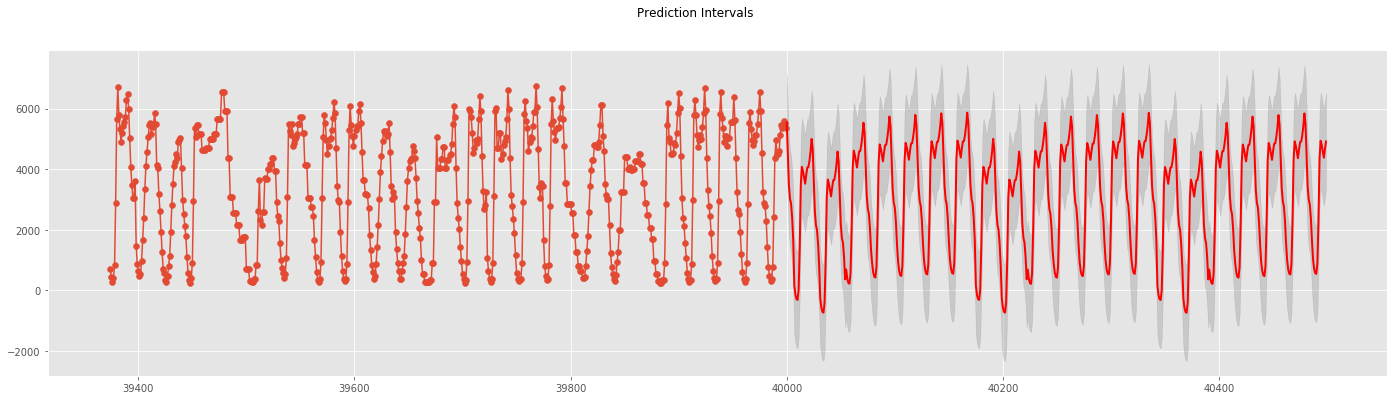

In [10]:
lasttime=pd.Timestamp('2017-12-22 16:00:00')

x_pred_index_no = range(40000,40500)
x_pred_time = [lasttime+i*pd.Timedelta('1:00:00') for i in range (1, len(x_pred_index_no)+1)]

newdf = pd.DataFrame(index=x_pred_time,columns=['index_no'], data= x_pred_index_no)

newdf['year']=newdf.index.year-2012
newdf['monthofyear']=newdf.index.month
newdf['dayofmonth']=newdf.index.day
newdf['dayofweek']=newdf.index.dayofweek
newdf['hour']=newdf.index.hour

y_pred = model.predict(newdf)
transformed_exog = transform_exog_to_model(model, newdf)
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(model, transformed_exog, weights=[1])

train1_partial=train1['2017-12':]
fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(train1_partial['index_no'], train1_partial['TrafficVolume'])
ax.scatter(train1_partial['index_no'], train1_partial['TrafficVolume'])
fig.suptitle('Prediction Intervals')
ax.grid(True)
ax.plot(list(x_pred_index_no), y_pred, '-', color='red', linewidth=2)
# interval for observations
ax.fill_between(x_pred_index_no, iv_l, iv_u, color='#888888', alpha=0.3)
ax.axis('tight')
plt.show()

In [11]:
##currrent model 

model.rsquared_adj #0.8342458234468448
model.aic #649414.3643822919

##full model
possible_feature=['index_no','hour','C(hour)','dayofweek','C(dayofweek)', 'dayofmonth','C(dayofmonth)','dayofyear','C(dayofyear)','C(weekofyear)','weekofyear','C(monthofyear)','monthofyear','year']
modelfull = modelFitting('TrafficVolume', possible_feature, train1)
modelfull.rsquared_adj  #0.8455436886541244
modelfull.aic #647034.5910585566

##foward  selection
#modelfwd=forward('TrafficVolume', possible_feature, train1, criterion="AIC", fullmodel = None) ##FWD in the following order
possible_feature=['C(hour)', 'C(dayofweek)', 'C(dayofyear)', 'C(weekofyear)', 'C(dayofmonth)', 'C(monthofyear)', 'index_no', 'year', 'weekofyear']
modelfwd=modelFitting('TrafficVolume', possible_feature, train1)

modelfwd.rsquared_adj #0.8455436886541244
modelfwd.aic #647034.5910585565

647034.5910585565

## 1-12 Diagnostic

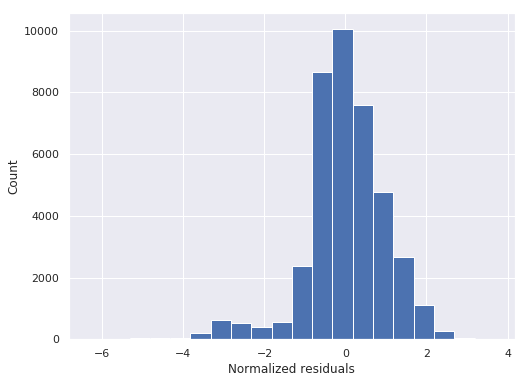

<Figure size 720x720 with 0 Axes>

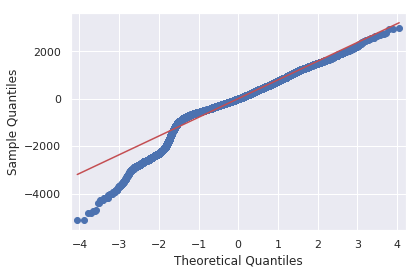

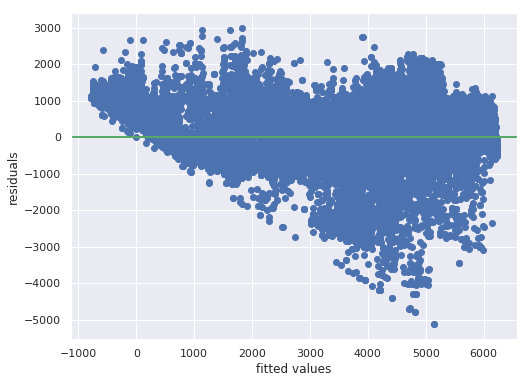

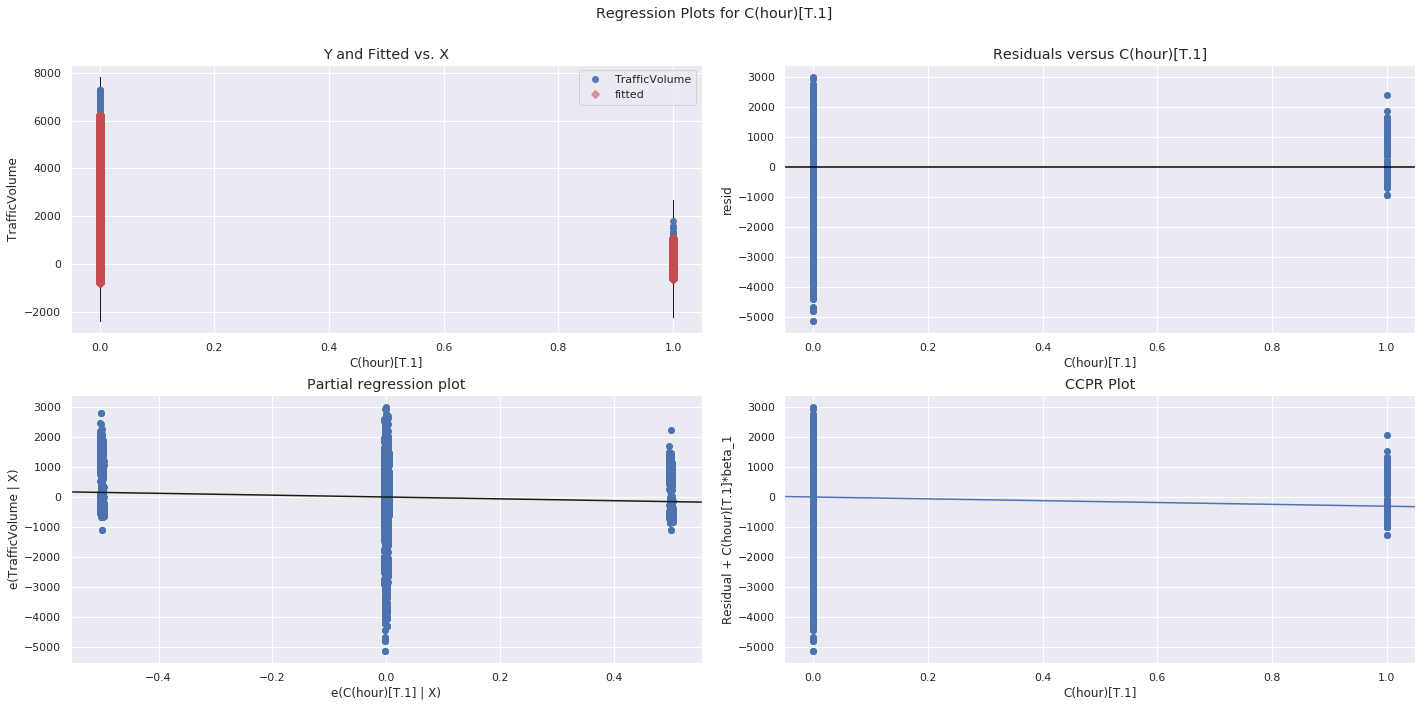

In [12]:
import scipy.stats as stats      #for normal distrib

def diagnosisplot(lm,Features):
    '''plotting Histogram of normalized residuals
       quantile-quantile plot of the residuals
       residuals against fitted value
       partial plots'''
    #1-1Histogram of normalized residuals
    res = lm.resid
    f1 = plt.figure(figsize=(8,6))
    f1 = plt.hist(lm.resid_pearson,bins=20)
    f1 = plt.ylabel('Count')
    f1 = plt.xlabel('Normalized residuals') 

    #1-2 check the normality of the residuals
    #quantile-quantile plot of the residuals
    fig2 = plt.figure(figsize=(10,10))
    fig = sm.qqplot(lm.resid, stats.distributions.norm, line='r') 
    
    #1-3 residuals against fitted value
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    ax.scatter(lm.fittedvalues,lm.resid)
    ax.axhline(y=0, linewidth=2, color = 'g')
    ax.set(xlabel='fitted values',ylabel='residuals')
    
    #2 partial plots
    for i in range(0,len(Features)):
        fig1 = plt.figure(figsize=(20,10))
        fig1 = sm.graphics.plot_regress_exog(lm, Features[i],fig=fig1)        

#plots for simple modal 
sns.set(font_scale=1)    
diagnosisplot(model,model.params.index.to_list()[1:2]) ##delete the "2" if want to see all variables 

#plots for simple modal with sqrt 

# Step 2 

## 2-1 Moving average 
under assumptions that observations follow a constant trend modal 

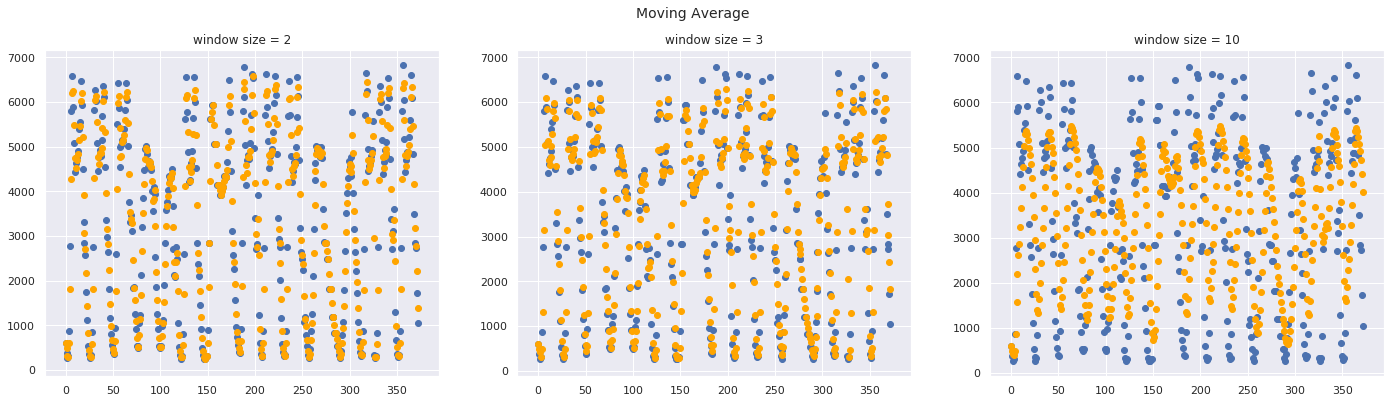

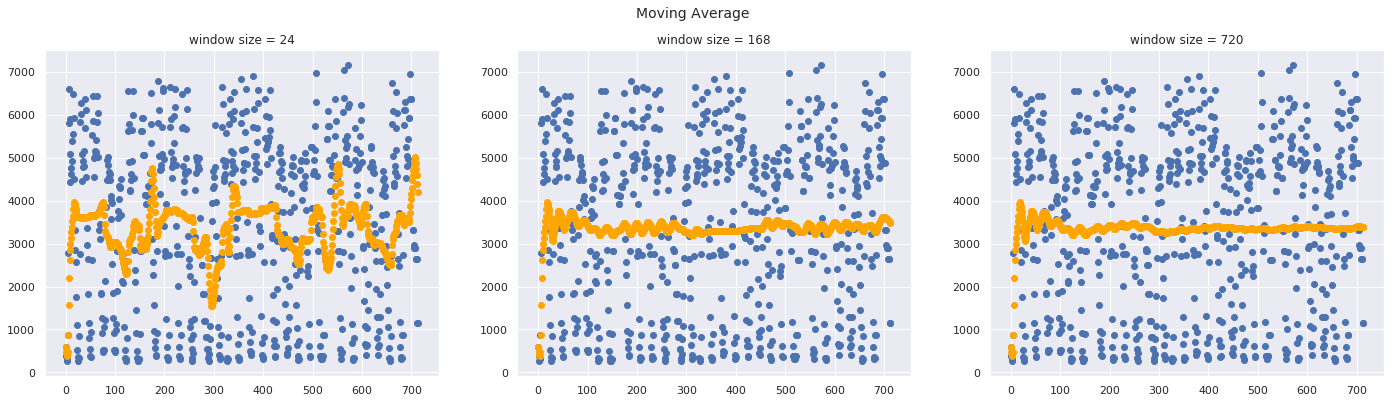

In [13]:
def plot_moving_averages(df,wins,y):
    fig, ax = plt.subplots(1,len(wins),figsize=(24,6))
    fig.suptitle("Moving Average", fontsize=14)
    
    def plot_moving_average(df,win,j,y):
        ma = df[y].rolling(window=win, min_periods=0, center=False)
        ax[j].scatter(x=range(0,df.shape[0]), y=df[y])
        ax[j].scatter(x=range(0,df.shape[0]), y=ma.mean(), color='orange')
        ax[j].title.set_text('window size = {}'.format(win))
    
    for j in range(0,len(wins)):
        plot_moving_average(df,wins[j],j,y)

y='TrafficVolume'  
df=train['2017-02-01':'2017-02-15']        
wins=[2,3,10]
plot_moving_averages(df,wins,y)

df=train['2017-02']
wins=[24,168,720] # 24*7 and 24*30
plot_moving_averages(df,wins,y)

## 2-2 Exponentially weighted moving average 
under assumptions that observations follow a constant trend modal

### 2-21 EWMA

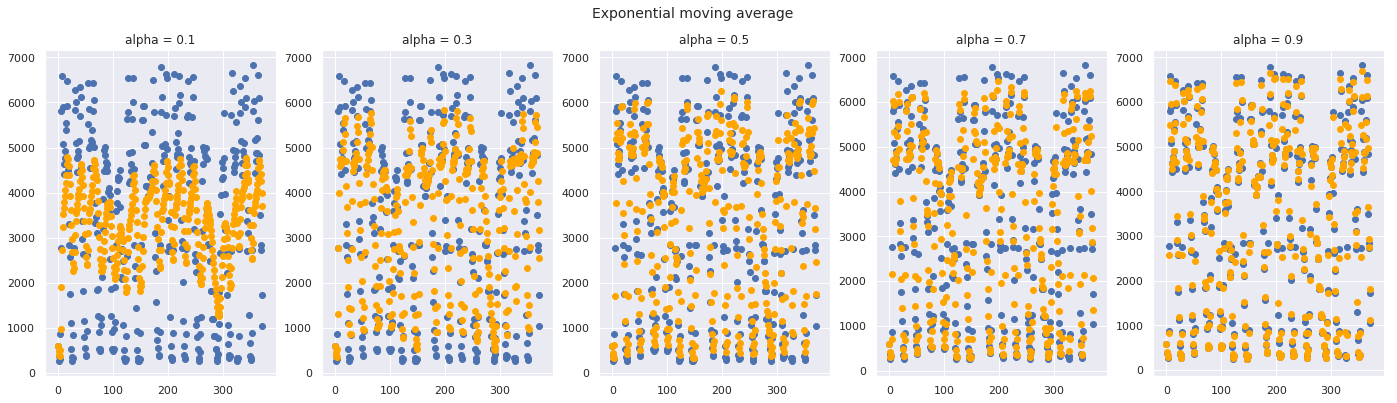

In [14]:
def plot_ewmas(df,als,y):
    def plot_ewma(df,al,j,y):
        ewma = df[y].ewm(alpha=al, min_periods=0)
        ax[j].scatter(x=range(0,df.shape[0]), y=df[y])
        ax[j].scatter(x=range(0,df.shape[0]), y=ewma.mean(), color='orange')
        ax[j].title.set_text('alpha = {}'.format(al))
    fig, ax = plt.subplots(1,len(als),figsize=(24,6))
    fig.suptitle("Exponential moving average", fontsize=14)
    for j in range(0,len(als)):
        plot_ewma(df,als[j],j,y)

df=train['2017-02-01':'2017-02-15']
y='TrafficVolume'
als=[0.1,0.3,0.5,0.7,0.9]

plot_ewmas(df,als,y)

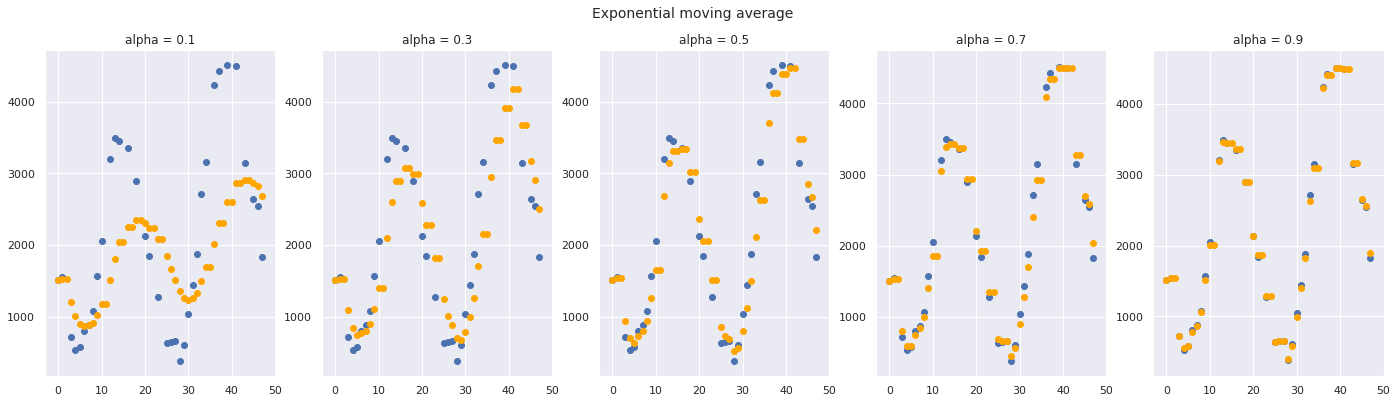

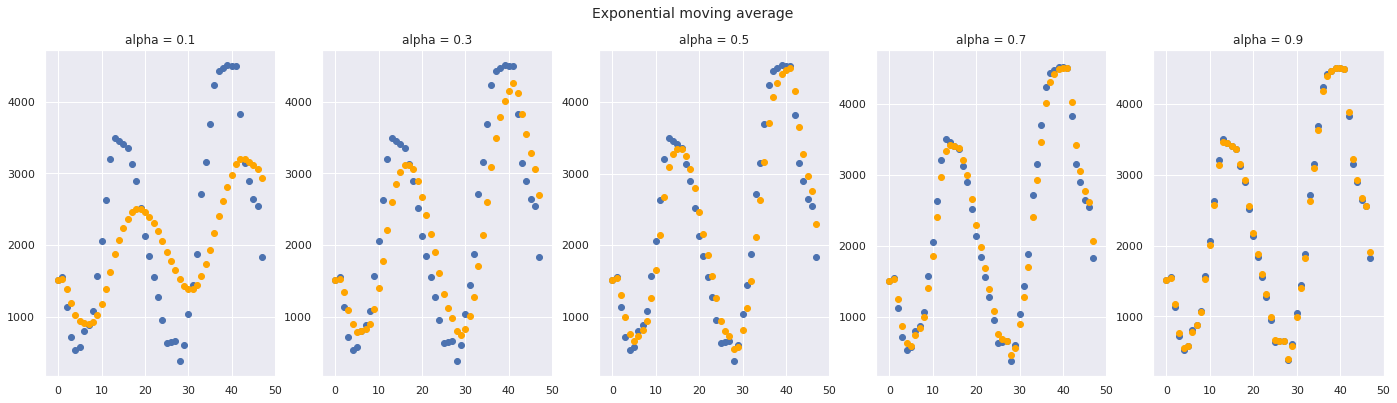

In [15]:
y='TrafficVolume'
als=[0.1,0.3,0.5,0.7,0.9]

df=train.resample('H').first()['2016-1-01':'2016-1-02']
plot_ewmas(df,als,y)

df=train.resample('H').first().interpolate()['2016-1-01':'2016-1-02']
plot_ewmas(df,als,y)

### 2-22 selecting the smoothing parameters to minimize error 
SSE = sum[Y(i)-L(i-1)]² 
L(n) = alpha* Y(n) + (1-alpha)*L(n-1) = sum over i=1 to n of [(alpha*(1-alpha)^(n-i))*Y(i)]
L(n-1) = previous mean values 
if alpha = 1  then L(n)=Y(n) ie the prediction is equal to the data 

Text(0.5, 1.0, 'prediction error given alpha with optimal alpha = 1.0')

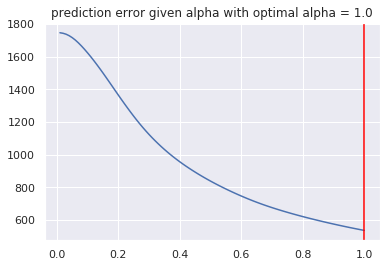

In [16]:
df=train
alpha = np.linspace(0.01,1,num=100)
err = [];
sses = pd.DataFrame()
for al in alpha:
    ewma = df[y].ewm(alpha=al, min_periods=0)  
    pred = ewma.mean(); # compute L 
    diff = df[y] - pred.shift(1);  ## we compare Y(i) and L(i-1)
    sse=np.sqrt(diff ** 2)
    sses['sse'+str(al)]=sse
    err.append(sse.mean())
    
plt.plot(alpha, err)
optal = alpha[np.argmin(err)]
plt.axvline(x=optal, color='red')
plt.title('prediction error given alpha with optimal alpha = {}'.format(optal))

In [17]:
df=train
df[y]

Time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
                       ... 
2017-12-22 12:00:00    5447
2017-12-22 13:00:00    5349
2017-12-22 14:00:00    5581
2017-12-22 15:00:00    5510
2017-12-22 16:00:00    5346
Name: TrafficVolume, Length: 40000, dtype: int64

In [18]:
ewma = df[y].ewm(alpha=1, min_periods=0)  
pred = ewma.mean(); # compute L 
print(pred)

Time
2012-10-02 09:00:00    5545.0
2012-10-02 10:00:00    4516.0
2012-10-02 11:00:00    4767.0
2012-10-02 12:00:00    5026.0
2012-10-02 13:00:00    4918.0
                        ...  
2017-12-22 12:00:00    5447.0
2017-12-22 13:00:00    5349.0
2017-12-22 14:00:00    5581.0
2017-12-22 15:00:00    5510.0
2017-12-22 16:00:00    5346.0
Name: TrafficVolume, Length: 40000, dtype: float64


In [19]:
diff = df[y] - pred.shift(1);  ## we compare Y(i) and L(i-1)
diff

Time
2012-10-02 09:00:00       NaN
2012-10-02 10:00:00   -1029.0
2012-10-02 11:00:00     251.0
2012-10-02 12:00:00     259.0
2012-10-02 13:00:00    -108.0
                        ...  
2017-12-22 12:00:00     308.0
2017-12-22 13:00:00     -98.0
2017-12-22 14:00:00     232.0
2017-12-22 15:00:00     -71.0
2017-12-22 16:00:00    -164.0
Name: TrafficVolume, Length: 40000, dtype: float64

In [20]:
sse=np.sqrt(diff ** 2)
sse

Time
2012-10-02 09:00:00       NaN
2012-10-02 10:00:00    1029.0
2012-10-02 11:00:00     251.0
2012-10-02 12:00:00     259.0
2012-10-02 13:00:00     108.0
                        ...  
2017-12-22 12:00:00     308.0
2017-12-22 13:00:00      98.0
2017-12-22 14:00:00     232.0
2017-12-22 15:00:00      71.0
2017-12-22 16:00:00     164.0
Name: TrafficVolume, Length: 40000, dtype: float64

### 2-23 Assumptions verifications

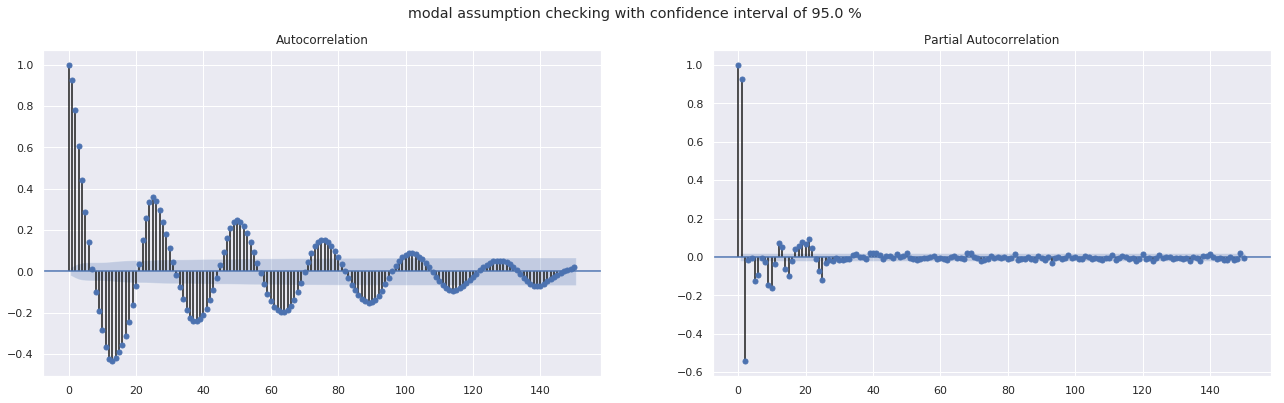

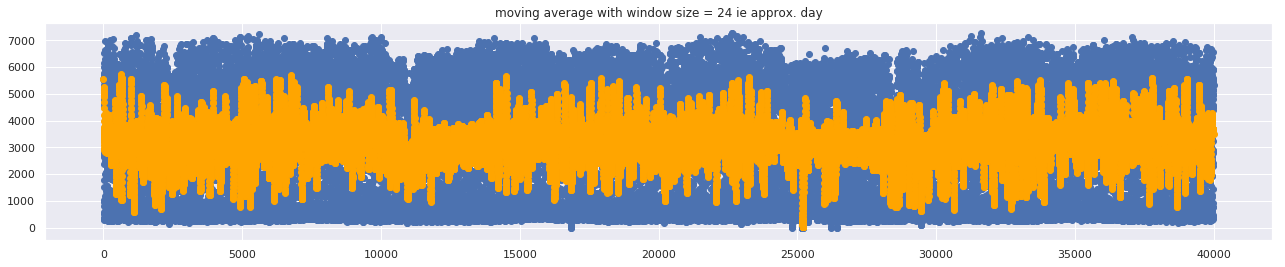

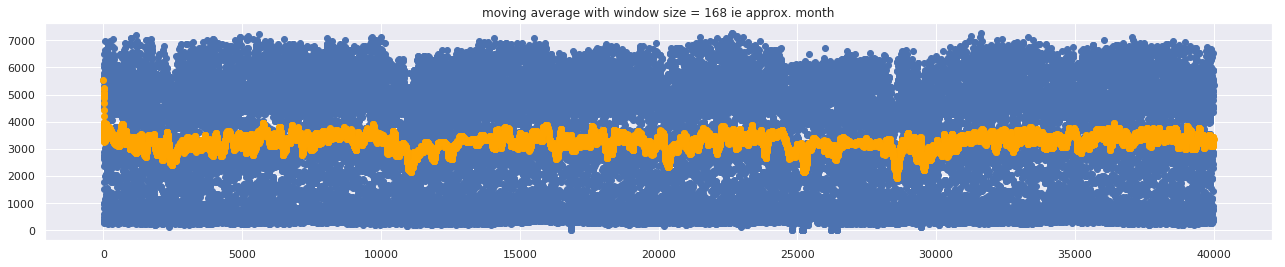

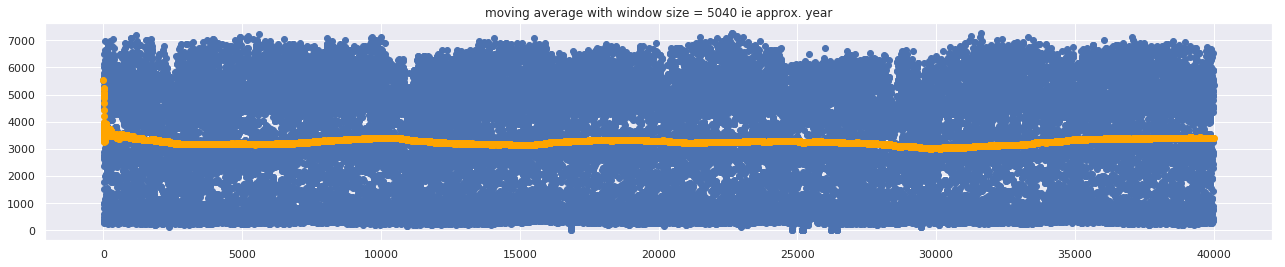

In [21]:
## seasonal testing
alpha=0.05 # 95 % confidence intervals 
lags =150
#24*7=168
#168*30=5040
data =train['TrafficVolume']['2017']
fig, ax = plt.subplots(1,2,figsize=(22,6))
fig.suptitle('modal assumption checking with confidence interval of {} % '.format((1-alpha)*100))
fig = sgt.plot_acf(data, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
fig = sgt.plot_pacf(data, ax=ax[1], lags=lags, alpha=alpha, method='ols')

## trend testing
df=train
y='TrafficVolume'
wins =[24,24*7,24*7*30]
wins_exp = {24 : 'approx. day',24*7 :'approx. month', 24*7*30 : 'approx. year'}
for win in wins :
    fig, ax = plt.subplots(1,1,figsize=(22,4))
    ma = df[y].rolling(window=win, min_periods=0, center=False)
    ax.scatter(x=range(0,df.shape[0]), y=df[y])
    ax.scatter(x=range(0,df.shape[0]), y=ma.mean(), color='orange')
    ax.title.set_text('moving average with window size = {} ie {}'.format(win,wins_exp[win]))

## 2-3 Trend Corrected Smoothing 

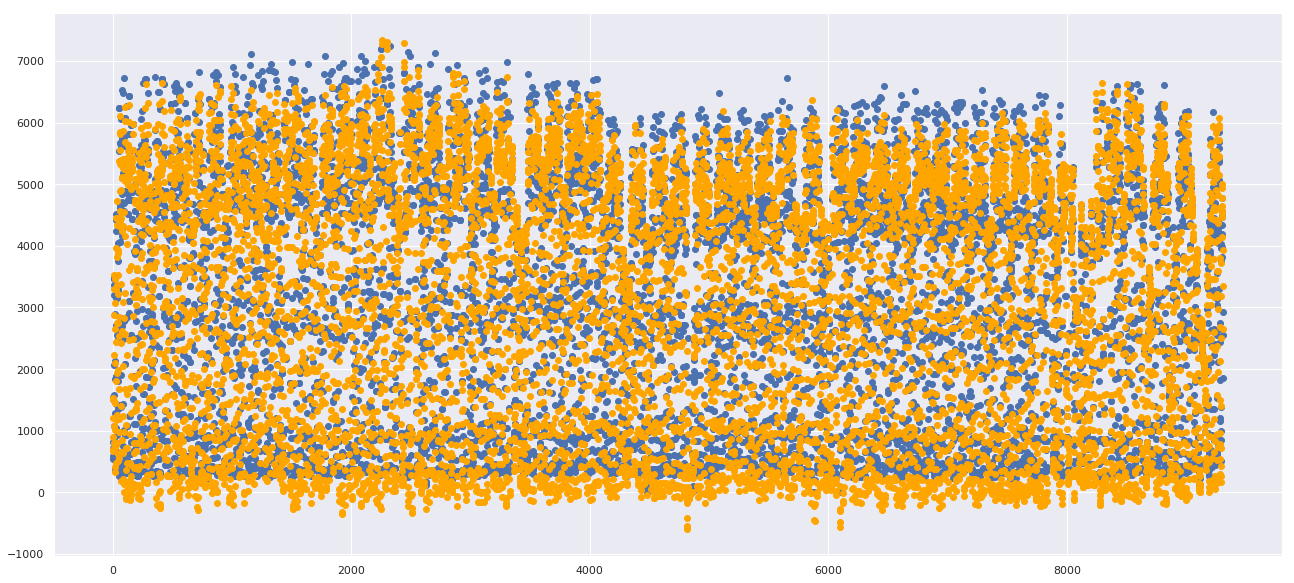

In [22]:
def double_exponential_smoothing(series, alpha, beta, L0, B0):
    result = []
    for n in range(0, len(series)):
        val = series[n]
        if n==0:
            level = alpha*val + (1-alpha)*(L0+B0); ##level(1)
            trend = beta*(level-L0) + (1-beta)*B0; ##trend(1)
            last_level = level;
        else:
            level = alpha*val + (1-alpha)*(last_level+trend) #trend = B(n-1)
            trend = beta*(level-last_level) + (1-beta)*trend
            last_level = level;
            
        result.append(level)
    return result

alpha = 0.4; #
beta = 0.2; #
df=train['2016']
y='TrafficVolume'
series = df[y].values
holt = double_exponential_smoothing(series, alpha, beta,series[0], series[1]-series[0])
fig = plt.figure(figsize=(22,10))
plt.scatter(x=range(0,df.shape[0]), y=df[y])
plt.scatter(x=range(0,df.shape[0]), y=holt, color='orange')

## 2-3 Holt-WInters Smoothing  Y(t)= b0+ SN(t) + e(t)
Supposed form of observation Y : Y(t)= B0 + beta1*t +e(t)

Prediction/level L : L(n) = alpha *Y(n) + (1-alpha)*(L(n-1)+ B(n-1))

Trend term B(n) = beta*(L(n)-L(n-1)) + (1-beta)*beta(n-1) given a series, alpha and beta, return series of smoothed points

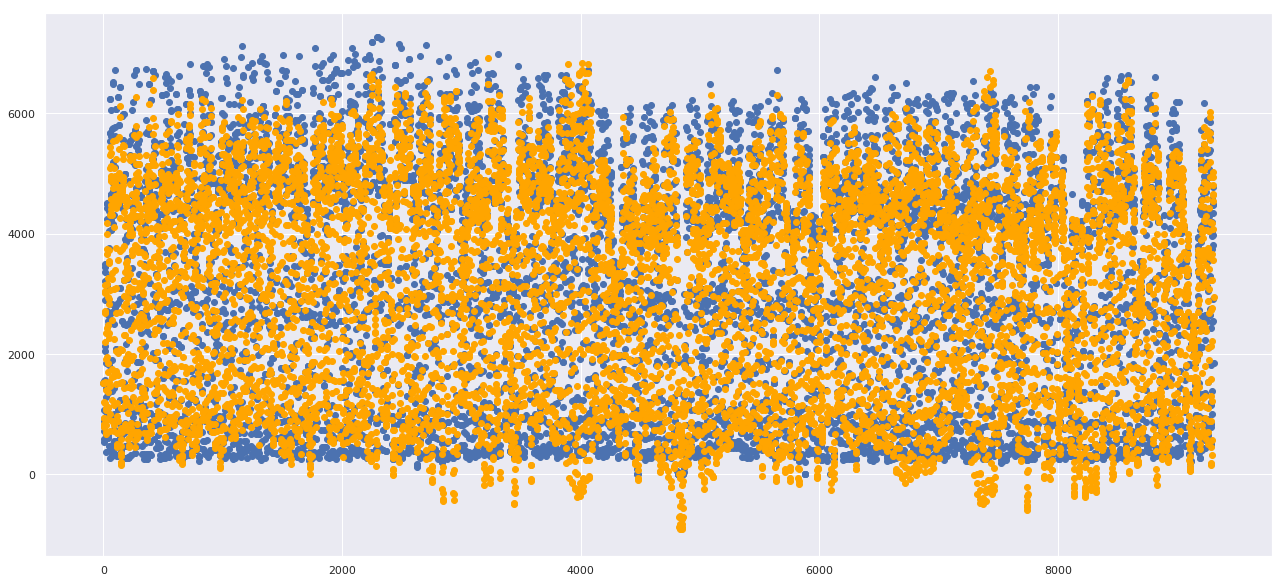

In [23]:
def HoltWinters(series, alpha, beta, L0, B0):
    result = []
    seasons= []
    L=24 #period of hours
    for n in range(0, len(series)):
        val = series[n]
        
        #initiation of 1
        if n==0:
            level = alpha*(val - 0) + (1-alpha)*(L0); ##level(1)
            season = beta*(val-L0) + 0  ; ##season(1)
            seasons.append(season) # we store the season term in seasons
            last_level = level; # we store the current level in last_level
        
        #initiation of 2 to 23 for season terms
        elif (n!=0 and n-23<=0):
            level = alpha*(val - 0) + (1-alpha)*(last_level);
            season = beta*(val-level) + 0 ;
            seasons.append(season)
            last_level = level; 
        
        else:
            ##level(n) need season(n-L) with L=24 
            ##since season(n) has not been appended to seasons, season(n-L) = seasons[-L+1]
            level = alpha*(val - seasons[-L+1]) + (1-alpha)*(last_level);
            season = beta*(val-level) + (1-beta)* + seasons[-L+1];
            seasons.append(season)
            last_level = level; 
            
        result.append(level)
    return result

alpha = 0.4; #
beta = 0.1; #
df=train['2016']
y='TrafficVolume'
series = df[y].values
holt = HoltWinters(series, alpha, beta,series[0], series[1]-series[0])
fig = plt.figure(figsize=(22,10))
plt.scatter(x=range(0,df.shape[0]), y=df[y])
plt.scatter(x=range(0,df.shape[0]), y=holt, color='orange')

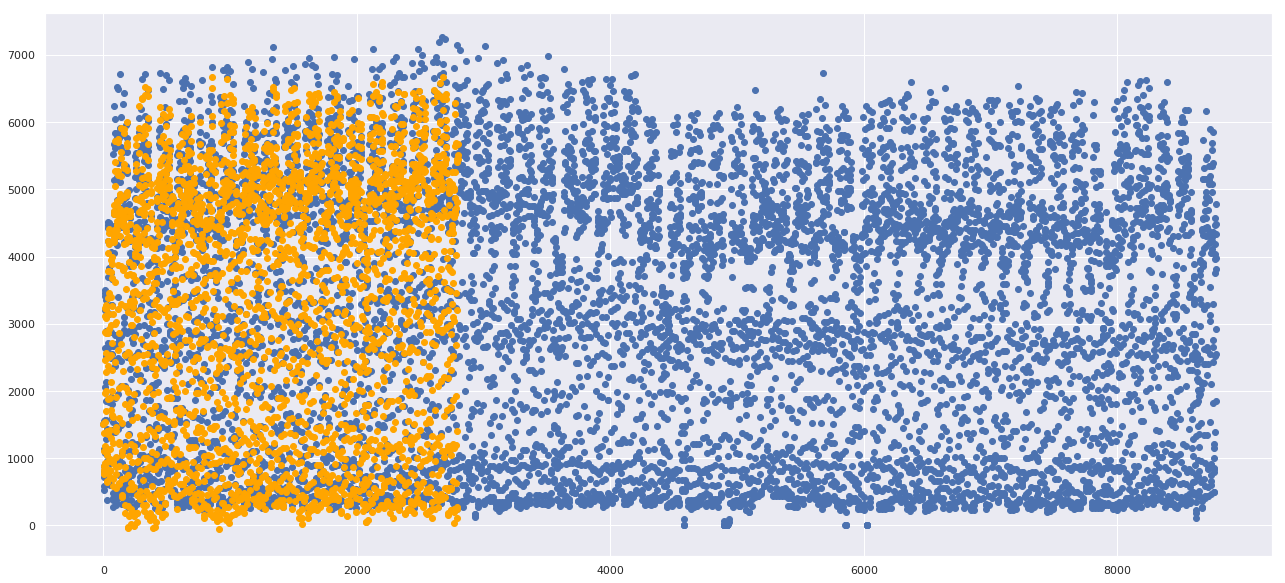

In [24]:
alpha = 0.4; #
beta = 0.1; #
df=train.resample('H').first().interpolate(limit=3)['2016']
y='TrafficVolume'

series = df[y].values
holt = HoltWinters(series, alpha, beta,series[0], series[1]-series[0])
fig = plt.figure(figsize=(22,10))
plt.scatter(x=range(0,df.shape[0]), y=df[y])
plt.scatter(x=range(0,df.shape[0]), y=holt, color='orange')

1.0


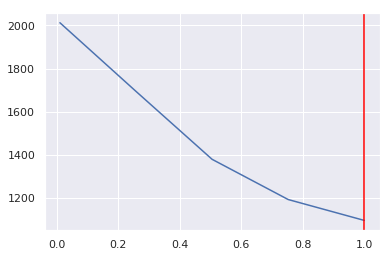

In [27]:
alphas = np.linspace(0.01,1,num=5)
betas = np.linspace(0.01,1,num=5)

series = df[y].values
err = [];
beta= 0
for alpha in alphas:
   # for beta in betas:
    holt = HoltWinters(series, alpha, beta,series[0], series[1]-series[0]);
    pred = pd.Series(holt,index=df.index);
    diff = df[y] - pred.shift(1);
    err.append(np.sqrt((diff ** 2).mean()))
    
plt.plot(alphas, err)
optal = alphas[np.argmin(err)]
plt.axvline(x=optal, color='red')
print(optal)

# Step 3 

##  3-1 Data Quality Issues

In [30]:
# 0-IsHoliday 
#seems to be only annotated for hour 0 of the related day
train['2016-01-01']

,IsHoliday,Temp,Rain1h,Snow1h,CloudsAll,WeatherMain,WeatherDescription,TrafficVolume
Time,,,,,,,,
2016-01-01 00:00:00,New Years Day,265.94,0.0,0.0,90,Haze,haze,1513
2016-01-01 00:00:00,New Years Day,265.94,0.0,0.0,90,Snow,light snow,1513
2016-01-01 01:00:00,None,266.00,0.0,0.0,90,Snow,light snow,1550
2016-01-01 03:00:00,None,266.01,0.0,0.0,90,Snow,light snow,719
2016-01-01 04:00:00,None,264.80,0.0,0.0,90,Clouds,overcast clouds,533
2016-01-01 05:00:00,None,264.38,0.0,0.0,90,Clouds,overcast clouds,586
2016-01-01 06:00:00,None,263.99,0.0,0.0,1,Clear,sky is clear,809
2016-01-01 07:00:00,None,264.16,0.0,0.0,1,Clear,sky is clear,882
2016-01-01 08:00:00,None,264.80,0.0,0.0,75,Clouds,broken clouds,1077


In [31]:
#some note even annotated ex : 2017-01-01 
train.loc['2017-01-01','IsHoliday']

Time
2017-01-01 00:00:00    None
2017-01-01 01:00:00    None
2017-01-01 02:00:00    None
2017-01-01 03:00:00    None
2017-01-01 04:00:00    None
2017-01-01 05:00:00    None
2017-01-01 06:00:00    None
2017-01-01 07:00:00    None
2017-01-01 08:00:00    None
2017-01-01 09:00:00    None
2017-01-01 10:00:00    None
2017-01-01 11:00:00    None
2017-01-01 12:00:00    None
2017-01-01 13:00:00    None
2017-01-01 14:00:00    None
2017-01-01 15:00:00    None
2017-01-01 16:00:00    None
2017-01-01 17:00:00    None
2017-01-01 18:00:00    None
2017-01-01 19:00:00    None
2017-01-01 20:00:00    None
2017-01-01 21:00:00    None
2017-01-01 22:00:00    None
2017-01-01 23:00:00    None
Name: IsHoliday, dtype: object

In [32]:
#1- Rain1h
#2016-07-11 17:00:00 have rainhour >9000 while surrounding values of rain is 0 ==>error we will put 0 
train.loc['2016-07-11 17','Rain1h']

9831.3

In [33]:
#Temperature with 0 K => impossible
train[train.Temp==0]

,IsHoliday,Temp,Rain1h,Snow1h,CloudsAll,WeatherMain,WeatherDescription,TrafficVolume
Time,,,,,,,,
2014-01-31 03:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,361
2014-01-31 04:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,734
2014-01-31 05:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,2557
2014-01-31 06:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,5150
2014-02-02 03:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,291
2014-02-02 04:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,284
2014-02-02 05:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,434
2014-02-02 06:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,739
2014-02-02 07:00:00,None,0.0,0.0,0.0,0,Clear,sky is clear,962


In [34]:
#3- Time series 
train.loc['2017-02-28 17'] ##gives 3 values for one unique hour

,IsHoliday,Temp,Rain1h,Snow1h,CloudsAll,WeatherMain,WeatherDescription,TrafficVolume
Time,,,,,,,,
2017-02-28 17:00:00,None,276.91,0.0,0.0,90,Drizzle,light intensity drizzle,6365
2017-02-28 17:00:00,None,276.91,0.0,0.0,90,Rain,moderate rain,6365
2017-02-28 17:00:00,None,276.91,0.0,0.0,90,Snow,light snow,6365


In [35]:
#count number of values by day 
train.loc['2012-12-16'] ## 81 values
print(train.loc['2012-12-16 10:00']) ##for a same hour, only the weathermain and weather description changes, Temp and Traffic vol remain the same 


                    IsHoliday    Temp  Rain1h  Snow1h  CloudsAll WeatherMain  \
Time                                                                           
2012-12-16 10:00:00      None  275.26     0.0     0.0         90        Rain   
2012-12-16 10:00:00      None  275.26     0.0     0.0         90        Mist   
2012-12-16 10:00:00      None  275.26     0.0     0.0         90     Drizzle   
2012-12-16 10:00:00      None  275.26     0.0     0.0         90     Drizzle   

                          WeatherDescription  TrafficVolume  
Time                                                         
2012-12-16 10:00:00               light rain           3021  
2012-12-16 10:00:00                     mist           3021  
2012-12-16 10:00:00  light intensity drizzle           3021  
2012-12-16 10:00:00                  drizzle           3021  


Text(0.5, 1.0, 'TrafficVolume by date')

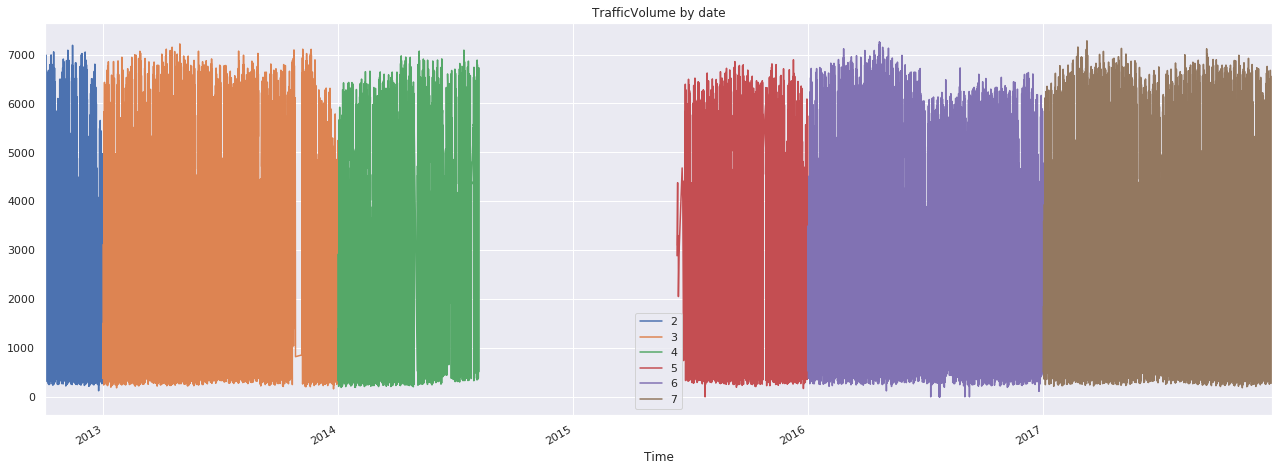

In [36]:
#Missing values per year
plt.figure(figsize=(22,8))
train.TrafficVolume['2012'].plot()
train.TrafficVolume['2013'].plot()
train.TrafficVolume['2014'].plot()
train.TrafficVolume['2015'].plot()
train.TrafficVolume['2016'].plot()
train.TrafficVolume['2017'].plot()
plt.legend('234567',loc='best')
plt.title('TrafficVolume by date')

##  3-2 Data Quality fixes

In [37]:
train = pd.read_csv('data/P2train.csv', parse_dates=['Time'],index_col='Time',header=0)
test = pd.read_csv('data/P2test.csv', parse_dates=['Time'],index_col='Time',header=0)
test_index = pd.read_csv('data/P2test_index.csv', header=0)
##Fixes 
def preprocessing(train):
    def feature_engineering(train):
        #add extra time features 
        train['date'] = [train.index[i].date() for i in range(0,len(train))]
        train['hour']=train.index.hour
        train['day_name']=train.index.day_name()
        #dayofweek : s0 = monday and 6 = sunday
        train['dayofweek']=train.index.dayofweek
        train['dayofmonth']=train.index.day
        train['dayofyear']=train.index.dayofyear

        train['weekofyear']=train.index.weekofyear
        train['monthofyear']=train.index.month

        train['year']=train.index.year-2012
    feature_engineering(train)
    
    def cleaning(train):
        #0-IsHoliday
        def fillHolidays(train):
            '''It is only flagged for the first hour of the day. We will flag it for all hours
            additionnal remarks : 
            -some not even annotated ex : 2017-01-01 or labeled wrong ex 2016-12-25'''
            indexes= train[train.IsHoliday!='None'].index #list of confirmed holidays. 
            for i in indexes:
                train.loc[str(i)[0:10],'IsHoliday']='Holiday' ##take only the 10 first char ie the day and not hour
            train['IsHoliday']= np.where(train['IsHoliday']=='None', 0,1)
        
        #train.loc['2017-01-01','IsHoliday']='Holiday'
        #train[(train['monthofyear']==1) & (train['dayofmonth']==1)]'
        fillHolidays(train)
            
        #1-Rain1h
        def filterhigh(x):
            '''The record for most rainfall in a single hour is 12 inches (30.5 cm), set in Holt, Missouri,
            in 1947 (Source : earthscience)
            Methods : Filter out with high values and apply interpolation'''
            if x > 400: 
                return np.nan
            else :
                return x
        train.Rain1h=train.Rain1h.apply(filterhigh).interpolate()

        #2-Temp
        # We'll replace 0 with nan and apply interpolation
        train['Temp']=train['Temp'].replace(0, np.nan).interpolate()
    cleaning(train)

    
preprocessing(train)
preprocessing(test)

In [38]:
def preprocessing_resampling(train):
    '''Cleaning and resampling time 
    a-resample to have a clean data every hour 
    b-for multiple entries in an hour, took first values (impact on WeatherMain and Weather Description)
    c-fill the nan by interpolation'''
    train_resampled=train.resample('H').first().interpolate(limit=3) ## max consecutive nan filled by interpolation = 3 
    print('nber of rows before resample: {}'.format(train.shape[0]))
    print('nber of rows after resample: {}'.format(train_resampled.shape[0]))
    print()
    print('number of nan after interpolation: ')
    train_resampled.isnull().sum()
    return train_resampled
train_resampled=preprocessing_resampling(train)

nber of rows before resample: 40000
nber of rows after resample: 45776

number of nan after interpolation: 


## 3-2 Linear regression with features 

In [39]:
feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
model=modelFitting(y, feature_set, train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TrafficVolume   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     4603.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:30:24   Log-Likelihood:            -3.2382e+05
No. Observations:               40000   AIC:                         6.477e+05
Df Residuals:                   39953   BIC:                         6.481e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -907.5387    183.169     -4.955      0.000   -1266.554    -548.524
C(hour)[T.1]          -306.9957     27.210    -11.283      0.000    -360.327    -253.664
C(hour)[T.2]          -445.3872     27.262    -16.337      0.000    -498.822    -391.952
C(hour)[T.3]          -464.1687     27.330    -16.984      0.000    -517.737    -410.601
C(hour)[T.4]          -125.3699     27.092     -4.628      0.000    -178.471     -72.269
C(hour)[T.5]          1262.5894     27.267     46.305      0.000    1209.146    1316.033
C(hour)[T.6]          3342.9515     27.156    123.101      0.000    3289.725    3396.178
C(hour)[T.7]          3933.8714     27.204    144.606      0.000    3880.551    3987.192
C(hour)[T.8]          3792.6161     27.145    139.715      0.000    3739.410    3845.822
C(hour)[T.9]          3565.1276     27.408    130.075      0.000    3511.407    3618.848
C(hour)[T.10]         3357.4197     27.149    123.669      0.000    3304.208    3410.631
C(hour)[T.11]         3638.3983     27.649    131.593      0.000    3584.206    3692.591
C(hour)[T.12]         3878.8194     27.619    140.438      0.000    3824.685    3932.954
C(hour)[T.13]         3887.5502     27.870    139.487      0.000    3832.924    3942.176
C(hour)[T.14]         4095.2292     27.654    148.090      0.000    4041.027    4149.431
C(hour)[T.15]         4393.6597     27.802    158.034      0.000    4339.167    4448.152
C(hour)[T.16]         4818.0891     27.598    174.580      0.000    4763.996    4872.182
C(hour)[T.17]         4486.9366     27.790    161.458      0.000    4432.467    4541.406
C(hour)[T.18]         3414.6421     27.581    123.802      0.000    3360.582    3468.702
C(hour)[T.19]         2422.9016     27.621     87.720      0.000    2368.764    2477.039
C(hour)[T.20]         1986.8331     27.497     72.258      0.000    1932.939    2040.727
C(hour)[T.21]         1827.4517     27.447     66.582      0.000    1773.656    1881.248
C(hour)[T.22]         1364.2613     27.385     49.819      0.000    1310.587    1417.936
C(hour)[T.23]          626.0537     27.197     23.019      0.000     572.748     679.360
C(dayofweek)[T.1]      112.4995     15.018      7.491      0.000      83.063     141.936
C(dayofweek)[T.2]      166.5090     14.901     11.174      0.000     137.303     195.715
C(dayofweek)[T.3]      254.6976     14.879     17.118      0.000     225.535     283.860
C(dayofweek)[T.4]      242.6049     14.957     16.220      0.000     213.289     271.921
C(dayofweek)[T.5]     -638.1650     15.070    -42.347      0.000    -667.702    -608.628
C(dayofweek)[T.6]    -1057.5726     15.006    -70.476      0.000   -1086.985   -1028.160
C(monthofyear)[T.2]    156.1897     20.877      7.481      0.000     115.270     197.110
C(monthofyear)[T.3]    222.0006     21.152     10.496    

In [40]:
from statsmodels.stats import outliers_influence  #for VIF
for i in range(len(model.model.exog_names)):
     print('VIF for '+model.model.exog_names[i]+':'+str( outliers_influence.variance_inflation_factor(model.model.exog, i)))

VIF for Intercept:2128.2382475291097
VIF for C(hour)[T.1]:1.9154290034164823
VIF for C(hour)[T.2]:1.90992257757482
VIF for C(hour)[T.3]:1.9031854724157984
VIF for C(hour)[T.4]:1.9350797417908059
VIF for C(hour)[T.5]:1.914870196659515
VIF for C(hour)[T.6]:1.9314183333665604
VIF for C(hour)[T.7]:1.926454870528734
VIF for C(hour)[T.8]:1.9320397379207837
VIF for C(hour)[T.9]:1.8933055178633718
VIF for C(hour)[T.10]:1.9282074086806948
VIF for C(hour)[T.11]:1.8710291477452545
VIF for C(hour)[T.12]:1.8859489262005191
VIF for C(hour)[T.13]:1.8625557365646848
VIF for C(hour)[T.14]:1.90288151377432
VIF for C(hour)[T.15]:1.8861564641643636
VIF for C(hour)[T.16]:1.9129784653069453
VIF for C(hour)[T.17]:1.8845603476211588
VIF for C(hour)[T.18]:1.9040241100978763
VIF for C(hour)[T.19]:1.886150234477039
VIF for C(hour)[T.20]:1.8923161464117528
VIF for C(hour)[T.21]:1.8909270478230706
VIF for C(hour)[T.22]:1.894386329435818
VIF for C(hour)[T.23]:1.916827654733948
VIF for C(dayofweek)[T.1]:1.7269822790

In [41]:
#model selection :
from sklearn.model_selection import train_test_split

def model_evaluation(feature_set,train_X,train_y,y,random_state=42):
    '''feature_set : list of features for linear regresssion 
    train_X= data frame with no y
    train_y= data frame with y
    y= string '''

    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=random_state)
    X_train[y]=y_train
    model=modelFitting(y, feature_set, X_train)
    train_err=sum(np.abs(model.fittedvalues - y_train))/ len(y_train)
    train_mse=sum((model.fittedvalues - y_train)**2)/ len(y_train)
                  
    test_err=sum(np.abs(model.predict(X_test) - y_test))/ len(y_test)
    test_mse=sum((model.predict(X_test) - y_test)**2)/ len(y_test)
    print(feature_set)
    print('train errors = {} {}'.format(train_err, train_mse))
    print('test errors = {} {} '.format(test_err, test_mse))
    print()     
    #return train_err, train_mse, test_err, test_mse         

### Full model 

In [42]:
#Full model 
model_evaluation(['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(WeatherMain)', 'C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'year']
 ,train,train['TrafficVolume'],'TrafficVolume',random_state=2)   

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(WeatherMain)', 'C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'year']
train errors = 584.6513574452058 625246.0481775219
test errors = 591.5996289599499 644779.5192087727 



### Full model with backward selection

In [43]:
feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
#model_bw=backward(y, feature_set,train, criterion="AIC")
##returns ['IsHoliday', 'Rain1h']
#model_bw.summary()

### Full model with Forward selection

In [44]:
#forward=forward(y, feature_set, train)
#returns below 
'''feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
model = forward(y, feature_set,train, criterion="AIC")'''

feature_set_fwd= ['C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'Temp', 'CloudsAll', 'year', 'Snow1h']
#model=modelFitting(y, feature_set_fwd, train)
#model.summary()
model_evaluation(feature_set_fwd,train,train['TrafficVolume'],'TrafficVolume',random_state=2)

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['C(hour)', 'C(dayofweek)', 'C(monthofyear)', 'Temp', 'CloudsAll', 'year', 'Snow1h']
train errors = 585.4688157421853 651558.001919351
test errors = 591.9124987047085 667337.5674543632 



### Full model + interaction effects 

In [45]:
#Full model with interaction
X=feature_set
cand_2Inter = []
for p1 in X:
    for p2 in X:
        if p1 == p2:
            cand_2Inter.append(p1);
        else:
            cand_2Inter.append(p1+':'+p2)

model_evaluation(cand_2Inter,train,train['TrafficVolume'],'TrafficVolume',random_state=2)

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['IsHoliday', 'IsHoliday:Temp', 'IsHoliday:Rain1h', 'IsHoliday:Snow1h', 'IsHoliday:CloudsAll', 'IsHoliday:C(hour)', 'IsHoliday:C(dayofweek)', 'IsHoliday:C(monthofyear)', 'IsHoliday:year', 'Temp:IsHoliday', 'Temp', 'Temp:Rain1h', 'Temp:Snow1h', 'Temp:CloudsAll', 'Temp:C(hour)', 'Temp:C(dayofweek)', 'Temp:C(monthofyear)', 'Temp:year', 'Rain1h:IsHoliday', 'Rain1h:Temp', 'Rain1h', 'Rain1h:Snow1h', 'Rain1h:CloudsAll', 'Rain1h:C(hour)', 'Rain1h:C(dayofweek)', 'Rain1h:C(monthofyear)', 'Rain1h:year', 'Snow1h:IsHoliday', 'Snow1h:Temp', 'Snow1h:Rain1h', 'Snow1h', 'Snow1h:CloudsAll', 'Snow1h:C(hour)', 'Snow1h:C(dayofweek)', 'Snow1h:C(monthofyear)', 'Snow1h:year', 'CloudsAll:IsHoliday', 'CloudsAll:Temp', 'CloudsAll:Rain1h', 'CloudsAll:Snow1h', 'CloudsAll', 'CloudsAll:C(hour)', 'CloudsAll:C(dayofweek)', 'CloudsAll:C(monthofyear)', 'CloudsAll:year', 'C(hour):IsHoliday', 'C(hour):Temp', 'C(hour):Rain1h', 'C(hour):Snow1h', 'C(hour):CloudsAll', 'C(hour)', 'C(hour):C(dayofweek)', 'C(hour):C(monthofyear)

### Full model + interaction effects  with Forward selection

In [46]:
#feature_set=['IsHoliday', 'Temp', 'Rain1h', 'Snow1h', 'CloudsAll', 'C(hour)','C(dayofweek)','C(monthofyear)','year']
#forward_interaction=forward_interaction(y, feature_set, train)

##returns
feature_set_fwdinter=['C(hour):C(dayofweek)', 'C(hour):C(monthofyear)', 'C(dayofweek):C(monthofyear)',
             'C(monthofyear):year', 'Rain1h:C(dayofweek)', 'Temp:C(monthofyear)', 'CloudsAll:C(monthofyear)',
             'Rain1h:C(hour)', 'Rain1h:C(monthofyear)', 'Snow1h:C(hour)', 'C(dayofweek):year', 'C(hour):year',
             'Rain1h:year', 'Temp:C(dayofweek)', 'IsHoliday:C(monthofyear)', 'Temp:C(hour)',
             'CloudsAll:C(dayofweek)', 'CloudsAll:year', 'Temp:Rain1h', 'Temp:year']

#forward_interaction_model=modelFitting(y, feature_set_fwdinter, train)
#forward_interaction_model.summary()

#Forward selection with interaction
model_evaluation(feature_set_fwdinter,train,train['TrafficVolume'],'TrafficVolume',random_state=2)

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['C(hour):C(dayofweek)', 'C(hour):C(monthofyear)', 'C(dayofweek):C(monthofyear)', 'C(monthofyear):year', 'Rain1h:C(dayofweek)', 'Temp:C(monthofyear)', 'CloudsAll:C(monthofyear)', 'Rain1h:C(hour)', 'Rain1h:C(monthofyear)', 'Snow1h:C(hour)', 'C(dayofweek):year', 'C(hour):year', 'Rain1h:year', 'Temp:C(dayofweek)', 'IsHoliday:C(monthofyear)', 'Temp:C(hour)', 'CloudsAll:C(dayofweek)', 'CloudsAll:year', 'Temp:Rain1h', 'Temp:year']
train errors = 266.8327564518882 185920.64728265468
test errors = 266.3762082896097 181730.6721425726 



In [47]:
train_cleaned=train_resampled.dropna()
model_evaluation(cand_2Inter,train_cleaned,train_cleaned['TrafficVolume'],'TrafficVolume',random_state=2)

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['IsHoliday', 'IsHoliday:Temp', 'IsHoliday:Rain1h', 'IsHoliday:Snow1h', 'IsHoliday:CloudsAll', 'IsHoliday:C(hour)', 'IsHoliday:C(dayofweek)', 'IsHoliday:C(monthofyear)', 'IsHoliday:year', 'Temp:IsHoliday', 'Temp', 'Temp:Rain1h', 'Temp:Snow1h', 'Temp:CloudsAll', 'Temp:C(hour)', 'Temp:C(dayofweek)', 'Temp:C(monthofyear)', 'Temp:year', 'Rain1h:IsHoliday', 'Rain1h:Temp', 'Rain1h', 'Rain1h:Snow1h', 'Rain1h:CloudsAll', 'Rain1h:C(hour)', 'Rain1h:C(dayofweek)', 'Rain1h:C(monthofyear)', 'Rain1h:year', 'Snow1h:IsHoliday', 'Snow1h:Temp', 'Snow1h:Rain1h', 'Snow1h', 'Snow1h:CloudsAll', 'Snow1h:C(hour)', 'Snow1h:C(dayofweek)', 'Snow1h:C(monthofyear)', 'Snow1h:year', 'CloudsAll:IsHoliday', 'CloudsAll:Temp', 'CloudsAll:Rain1h', 'CloudsAll:Snow1h', 'CloudsAll', 'CloudsAll:C(hour)', 'CloudsAll:C(dayofweek)', 'CloudsAll:C(monthofyear)', 'CloudsAll:year', 'C(hour):IsHoliday', 'C(hour):Temp', 'C(hour):Rain1h', 'C(hour):Snow1h', 'C(hour):CloudsAll', 'C(hour)', 'C(hour):C(dayofweek)', 'C(hour):C(monthofyear)

In [48]:
y='TrafficVolume'
model=modelFitting(y, feature_set_fwdinter, train)

##compute the variance not explained 
train['error']=train.TrafficVolume-model.predict(train)
train['predict']=model.predict(train)

In [49]:
print('mse')
print((train.error**2).mean())
print('mae')
print( np.abs(train.error).mean())

mse
184188.7305479622
mae
264.99992900289476


### Step 1 — Stationarity Check (trend or seasonality component)  before we can use ARIMA to forecast

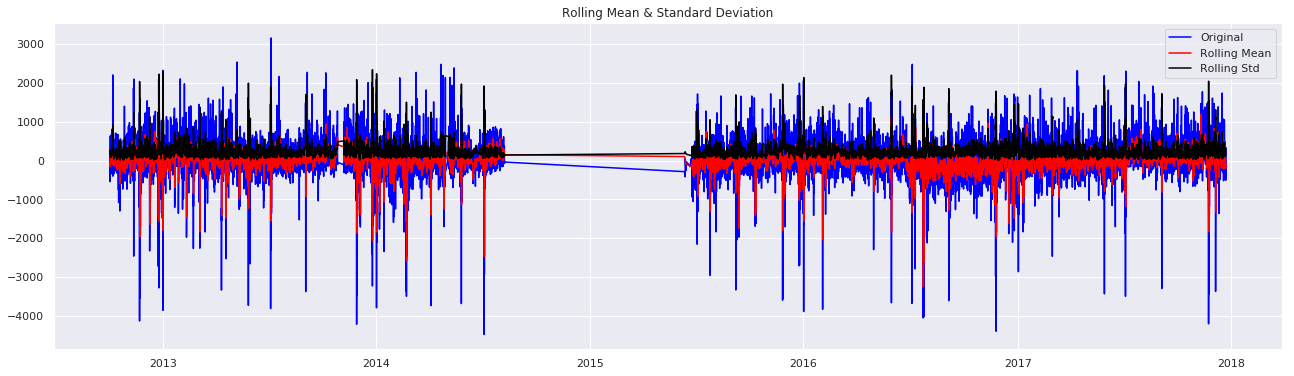

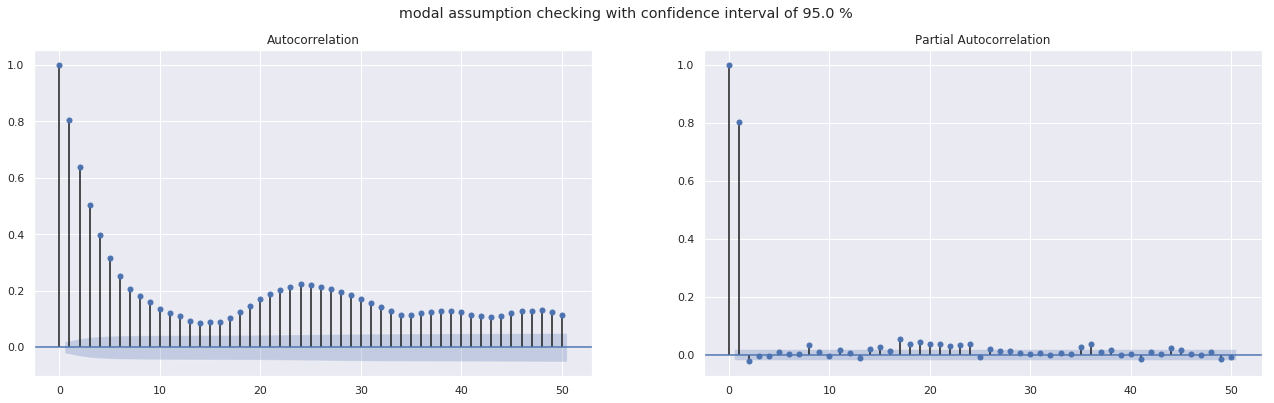

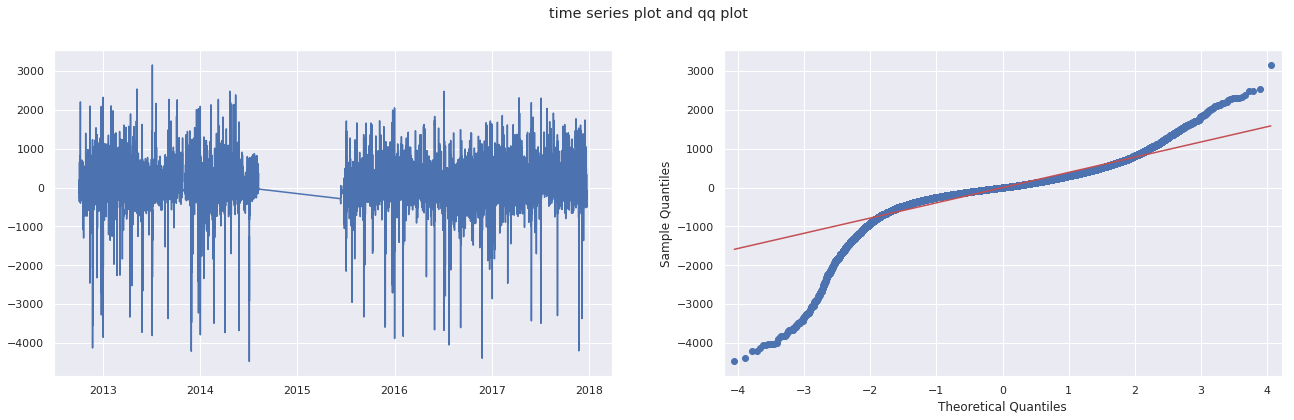

In [50]:
def test_arima(timeseries,window,lags_corr=50,alpha_corr=0.05):
    def test_stationarity(timeseries,window=12):
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window).mean()
        rolstd = timeseries.rolling(window=window).std()
        #Plot rolling statistics:
        plt.figure(figsize=(22,6))
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    test_stationarity(timeseries,window=12)
    
    def test_correlation_plot(timeseries,lags=lags_corr, alpha=alpha_corr):
        timeseries=timeseries['2016'] ##(-^-)##
        fig, ax = plt.subplots(1,2,figsize=(22,6))
        fig.suptitle('modal assumption checking with confidence interval of {} % '.format((1-alpha)*100)) 
        fig = sgt.plot_acf(timeseries, ax=ax[0], lags=lags, alpha=alpha, unbiased=True)
        fig = sgt.plot_pacf(timeseries, ax=ax[1], lags=lags, alpha=alpha, method='ols')
        
    test_correlation_plot(timeseries)
    
    def test_diagnostic_plot(timeseries):
        #time series plot
        fig, ax = plt.subplots(1,2,figsize=(22,6))
        fig.suptitle('time series plot and qq plot')
        ax[0].plot(timeseries)
        #qqplot
        fig = sm.qqplot(timeseries, stats.distributions.norm, line='r', ax=ax[1])
        
    test_diagnostic_plot(timeseries[24:,]) ##(-^-)##

test_arima(train.error,12)

### Step 2 — Make the series stationary : Differencing, Log...


In [51]:
df= train
y='error'
diff= df[y] - df[y].shift(1);  ## we compare Y(i) and L(i-1)
diff.dropna(inplace=True)

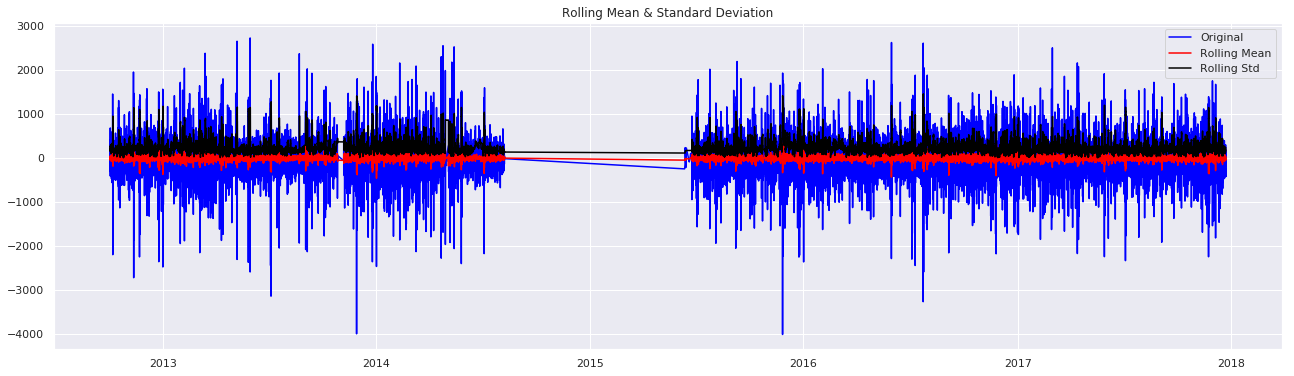

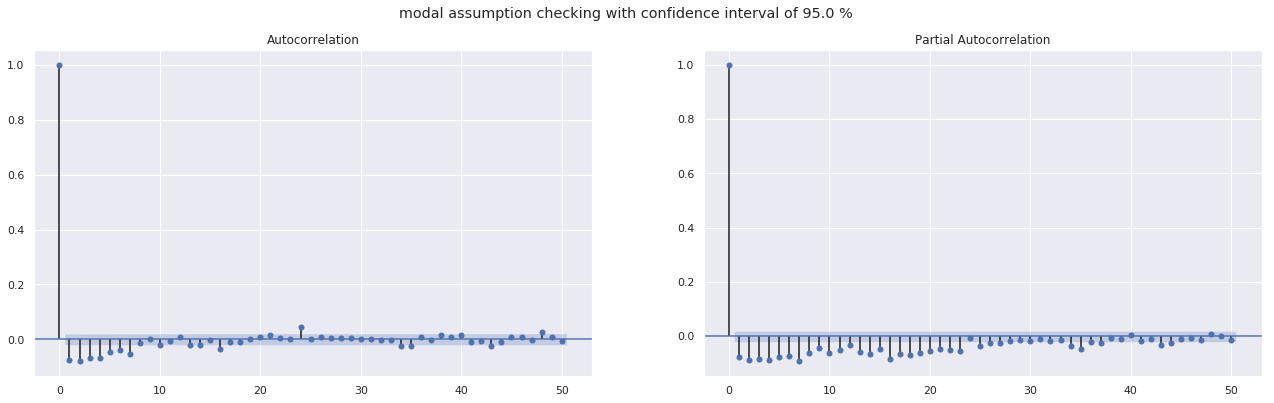

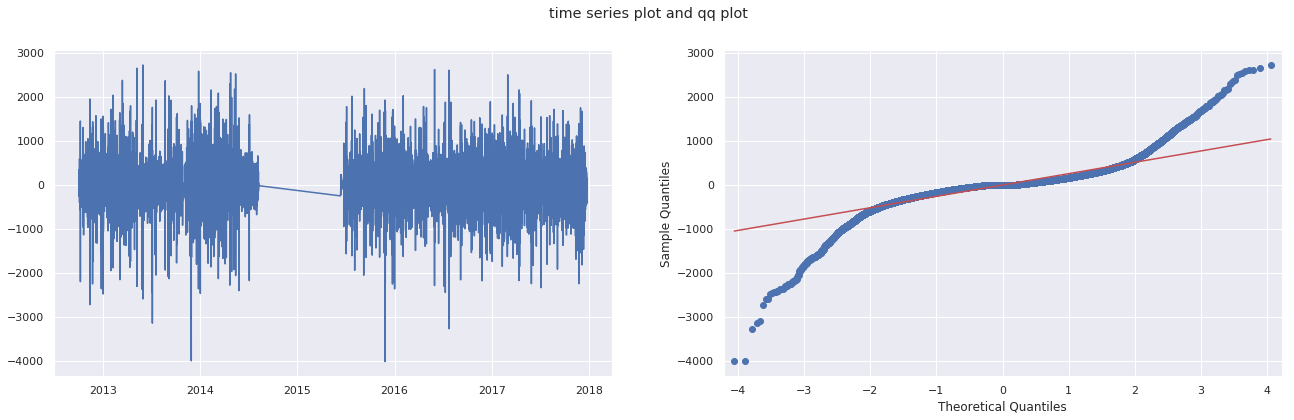

In [52]:
test_arima(diff,12)

### Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this
    

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/home/zhou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  error   No. Observations:                10718
Model:                     ARMA(2, 5)   Log Likelihood              -74360.847
Method:                       css-mle   S.D. of innovations            249.373
Date:                Sun, 17 Nov 2019   AIC                         148739.694
Time:                        20:31:55   BIC                         148805.211
Sample:                             0   HQIC                        148761.795
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.9482     21.631      2.032      0.042       1.552      86.345
ar.L1.error     1.4702      0.042     35.391      0.000       1.389       1.552
ar.L2.error    -0.4763      0.041    -11.745    

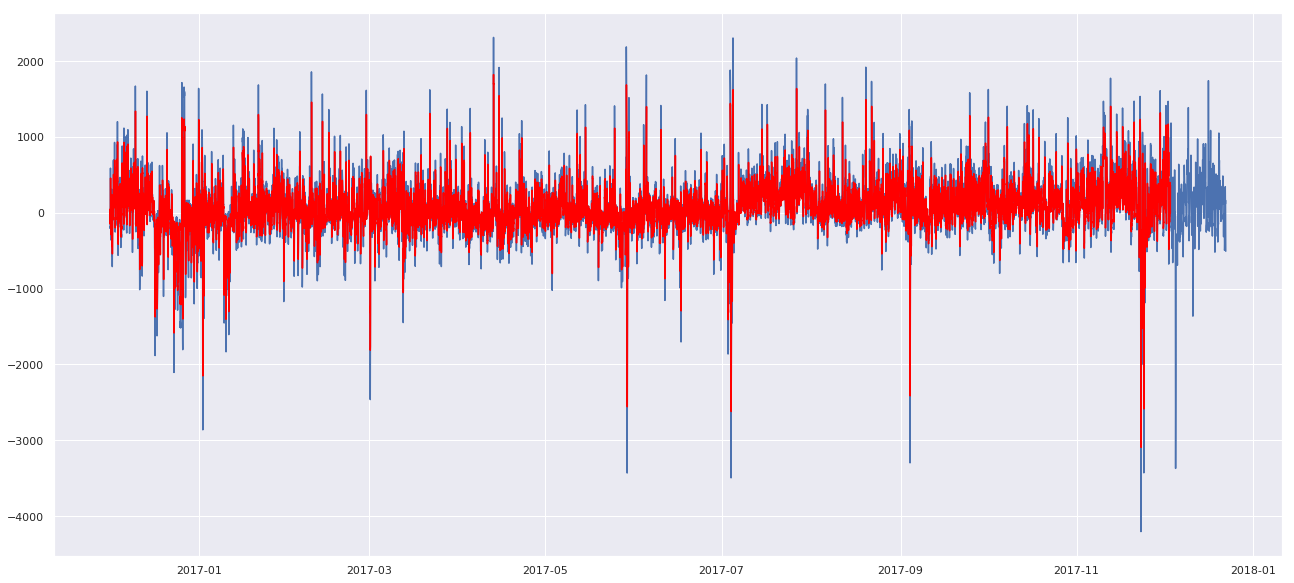

train_mae= 153.21585896248834
train_mse= 62191.07297043502


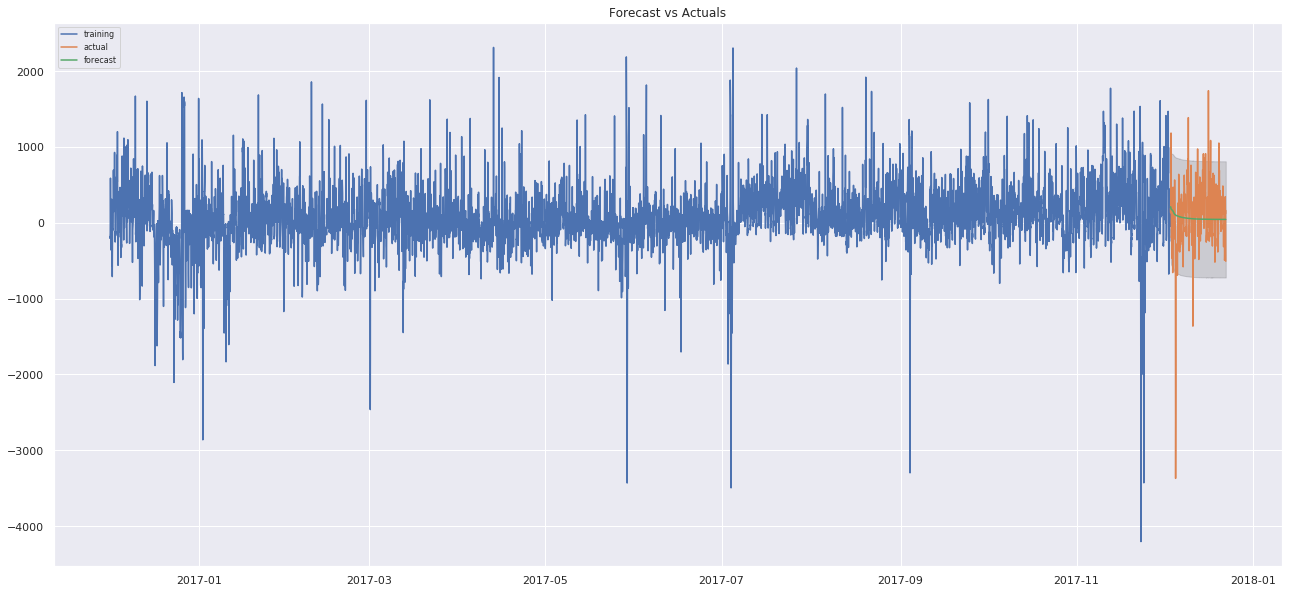

In [53]:
from statsmodels.tsa.arima_model import ARIMA

def evaluate_ARIMA(timeseries,order=(1,0,1),date=''):
    '''order = (p, d and q) and date is a string ex:'2017'  '''
    if date != '':
         timeseries=timeseries[date]
    
    def train_test_split(timeseries):
        n=timeseries.shape[0]
        n_train=int(n*0.95)
        
        train_err=timeseries[:n_train]
        test_err=timeseries[n_train:]
        return train_err,test_err
     
    train_err,test_err=train_test_split(timeseries)
    
    def modelfiting_plotting_errorcomputation(train_err,test_err):
        #fitting
        model = ARIMA(train_err, order=order)  
        model_fit = model.fit(disp=0) #disp : If True, convergence information is printed.
        print(model_fit.summary())
        
        pred=model_fit.fittedvalues
        #plotting
        if order[1]==0:
            plt.figure(figsize=(22,10))
            plt.plot(timeseries)
            plt.plot(pred, color='red')
            plt.show()
        
        #error computation
        print('train_mae= {}'.format(np.abs(train_err-pred).mean()))
        print('train_mse= {}'.format(((train_err-pred)**2).mean()))
        return model_fit
    model_fit=modelfiting_plotting_errorcomputation(train_err,test_err)
    
    def forecast(model_fit,train_err,test_err):
        # Forecast
        fc, se, conf = model_fit.forecast(test_err.shape[0], alpha=0.05)  # 95% conf, Out-of-sample forecast
        # Make as pandas series
        fc_series = pd.Series(fc, index=test_err.index)
        lower_series = pd.Series(conf[:, 0], index=test_err.index)
        upper_series = pd.Series(conf[:, 1], index=test_err.index)
    
        # Plot 
        plt.figure(figsize=(22,10))
        plt.plot(train_err, label='training')
        plt.plot(test_err, label='actual')
        plt.plot(fc_series, label='forecast') 
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                         color='k', alpha=.15)
        plt.title('Forecast vs Actuals')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
        
        #test_mae=np.abs(timeseries-pred).mean()
        #test_mse=((timeseries-pred)**2).mean()
        return [train_err,test_err,model_fit.fittedvalues,fc], model_fit
    return forecast(model_fit,train_err,test_err)

Lists,model_fit=evaluate_ARIMA(train.error, (2,0,5), train.index>'2016-12') 

In [54]:
Actual=Lists[1]
Fc=pd.Series(Lists[3],index=Actual.index,name='Fc')
Fc.iloc[100:410]
pd.concat([Actual,Fc],axis = 1)

,error,Fc
Time,,
2017-12-03 13:00:00,188.990007,210.310971
2017-12-03 14:00:00,131.878178,208.886532
2017-12-03 15:00:00,589.196783,204.488455
2017-12-03 16:00:00,877.067580,186.300606
2017-12-03 17:00:00,1183.214107,183.070338
2017-12-03 18:00:00,558.428951,180.684893
2017-12-03 19:00:00,-69.888799,178.716360
2017-12-03 20:00:00,-141.150174,176.958388
2017-12-03 21:00:00,-199.181811,175.311408


### Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.

In [82]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    # make predictions

    model = ARIMA(train, order=arima_order)
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(len(test))[0]
    # calculate out of sample error
    error = sum(np.abs(test-predictions))/len(test)
    
    print(arima_order)
    print(error)
    print()
    
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA %s MSE=%.3f' % (order,mse))
                except:
                    continue
    
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
p_values = [0, 1]
d_values = [0,1]
q_values = [0,1,2,3,4,5,6]
warnings.filterwarnings("ignore")
evaluate_models(train.error, p_values, d_values, q_values)

(0, 0, 0)
241.77530390202395

(0, 0, 1)
241.76930626888458

(0, 0, 2)
241.77377194625544

(0, 0, 3)
241.7738326213871

(0, 0, 4)
241.76735378051958

(0, 0, 5)
241.75995414584094

(0, 0, 6)
241.75884505307818

(0, 1, 0)
241.95240688081407

(0, 1, 1)
241.96533328679922

(0, 1, 2)
242.04371534569756

(0, 1, 3)
243.94508253710148

(0, 1, 4)
290.0393708620194

(0, 1, 5)
362.55994436890245

(0, 1, 6)
420.72000861528136

(1, 0, 0)
241.76892391625586

(1, 0, 1)
241.76845490311734

(1, 0, 2)
241.7684447599937

(1, 0, 3)
241.7682455689016

(1, 0, 4)
241.76887075678934

(1, 0, 5)
241.76888629013519

(1, 0, 6)
241.82495948364524

(1, 1, 0)
241.95763060487704

(1, 1, 2)
432.917599954715

(1, 1, 3)
437.40276008433375

(1, 1, 4)
441.9353619556599

(1, 1, 5)
445.16966579592844

(1, 1, 6)
447.44672609150075

Best ARIMANone MSE=inf



### Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [213]:
#test set preparation
l=[test.index[int(test_index.iloc[i])-1] for i in range(0,len(test_index))]
test[test.index.isin(l)]

#flag 1 if the value's index is in test_index
test['to_predict']=0
for i in range(0,len(test_index)):
    row_number=int(test_index.iloc[i])-1
    test['to_predict'].iloc[row_number]=1

test['index_no']= [x for x in range(1,len(test)+1)]
    

In [293]:
model.summary()
def forecast_linear_regression(model,test):
    test['pred_lr']=model.predict(test)

forecast_linear_regression(model,test)

''' IN PROGRESS
def predict(model,test,test_index):
    #entrée : une ligne ie date/heure et autres features 
    #sortie : Traffic Volume
    def forecast_linear_regression(model,test):
        test['pred_lr']=model.predict(test)

    def arima_modeling():
        #to be further developped
        #model_fit= ARIMA(test, order=arima_order)  
        #test['pred_arima']=model_fit.forecast(alpha=0.05)[0]'''


" IN PROGRESS\ndef predict(model,test,test_index):\n    #entrée : une ligne ie date/heure et autres features \n    #sortie : Traffic Volume\n    def forecast_linear_regression(model,test):\n        test['pred_lr']=model.predict(test)\n\n    def arima_modeling():\n        #to be further developped\n        #model_fit= ARIMA(test, order=arima_order)  \n        #test['pred_arima']=model_fit.forecast(alpha=0.05)[0]"

In [294]:
def formatting(test,l):
    #Half of the values to be predicted has a TrafficVolume... 
    Test2=test[test.index.isin(l)].drop_duplicates()
    Test2=Test2[Test2.to_predict==0].TrafficVolume
    Test2=Test2.drop_duplicates()
    submit= test[test.to_predict==1][['pred_lr','index_no']].join(Test2,lsuffix='_caller', rsuffix='_other')
    
    def select_result_row(row):
        if np.isnan(row['TrafficVolume']):
            return row['pred_lr']
        else :
            return row['TrafficVolume']

    submit['results'] = submit.apply(lambda row: select_result_row(row), axis=1)
    
    #index 8000 is dupplicated
    new_row = submit[submit.index_no==8000]
    res = submit.append(new_row, ignore_index=True)
    res=res.sort_values(by='index_no')
    res= res.drop(columns=['pred_lr','TrafficVolume','index_no'])
    return res

res=formatting(test,l)

In [296]:
res.to_csv('results_linear_regression.csv',header=False,index=False)